In [196]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
from skimage.transform import resize

from tensorflow import keras
from keras.models import Model, load_model
from keras.layers.merge import concatenate, add
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, Dropout, Activation, Input
from keras.optimizers import Adam

In [197]:
# Setting parameter variables
im_width = 256
im_height = 256
im_border = 5

In [198]:
# Initializing the train dataset
X = np.zeros((366, im_height, im_width, 3), dtype=np.float32)
Y = np.zeros((366, im_height, im_width, 3), dtype=np.float32)

In [199]:
# Creating the training data (input images)
IMAGE_PATH = "Documents/image_cell_seg/images"
i=0

for image in os.listdir(IMAGE_PATH):
    image_data = plt.imread(IMAGE_PATH +'/'+ image)
    image_data = resize(image_data, (256,256,3), mode='constant', preserve_range=True)
    #X[i] = image_data/(image_data.max()-image_data.min())  #Normalizing the input pixel values
    X[i] = image_data
    i+=1
    

In [200]:
# Creating the training data (mask labels)
MASK_PATH = "Documents/image_cell_seg/masks"
j=0

for mask in os.listdir(MASK_PATH):
    mask_data = cv2.imread(MASK_PATH +'/'+ mask, cv2.IMREAD_GRAYSCALE)
    mask_data = resize(mask_data, (256,256,3), mode='constant', preserve_range=True) 
    #Y[j] = mask_data/(mask_data.max()-mask_data.min())
    Y[j] = mask_data
    j+=1
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.049575683
1.0
2.0
0.0


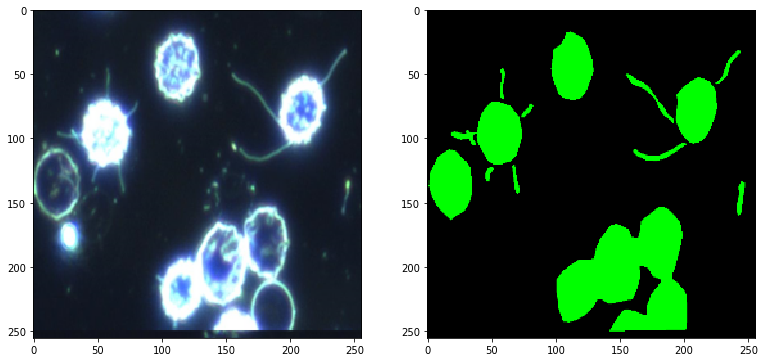

In [195]:
temp1 = plt.imread(IMAGE_PATH +'/'+ '189.png')
temp1 = resize(temp1, (256,256,3), mode='constant', preserve_range=True)
#temp1 = (temp1)/(temp1.max()-temp1.min())
temp2 = cv2.imread(MASK_PATH +'/' + '189.png', cv2.IMREAD_GRAYSCALE)
temp2 = resize(temp2, (256,256,3), mode='constant', preserve_range=True)
#temp2 = (temp2*255)/(temp2.max()-temp2.min())
print(temp1.min())
print(temp1.max())
print(temp2.max())
print(temp2.min())
fig = plt.figure(figsize=(20, 20))                
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(temp1)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(temp2)

In [201]:
print("The size of X is: " + str(X.shape))
print("The size of Y is: " + str(Y.shape))

The size of X is: (366, 256, 256, 3)
The size of Y is: (366, 256, 256, 3)


In [210]:
idx=189
print(Y[idx].max())
print(Y[idx].min())
print(X[idx].max())
print(X[idx].min())

0.0
0.0
1.0
0.044492323


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


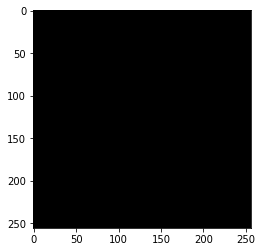

In [209]:
ix = 189
plt.imshow(Y[ix,:,:,:])
print(Y[ix,:,:,:])

In [28]:
def visualize(index):
    

In [222]:
def unet(input_layer, start_neurons, dropout):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(dropout)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(dropout)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(dropout)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(3, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    model = Model(inputs=[input_layer], outputs=[output_layer])
    
    return model


In [223]:
input_img = Input((im_height, im_width, 3))
model = unet(input_img, start_neurons=16, dropout=0.05)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [224]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_77[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_78[0][0]                  
____________________________________________________________________________________________

In [290]:
history = model.fit(X, Y, batch_size=16, epochs=1)

Epoch 1/1
366/366 [==============================] - 196s 535ms/step - loss: 0.0696 - accuracy: 0.9730


In [291]:
model.evaluate(X, Y, verbose=1)

366/366 [==============================] - 43s 117ms/step


[0.06902293018141731, 0.9732232689857483]

In [292]:
preds_train = model.predict(X, verbose=1)

366/366 [==============================] - 42s 115ms/step


In [293]:
preds_train.shape

(366, 256, 256, 3)

In [294]:
print(Y[0,:,:,:])

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         1.         0.        ]
  [0.         0.66015625 0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


In [295]:
preds_train[0,:,:,:]

array([[[1.54972076e-06, 8.45370293e-02, 5.96046448e-08],
        [0.00000000e+00, 2.78577507e-02, 0.00000000e+00],
        [0.00000000e+00, 1.77865624e-02, 0.00000000e+00],
        ...,
        [0.00000000e+00, 3.41588259e-03, 0.00000000e+00],
        [5.96046448e-08, 8.77115130e-03, 0.00000000e+00],
        [4.12762165e-05, 4.57145572e-02, 5.36441803e-07]],

       [[0.00000000e+00, 3.43899429e-02, 0.00000000e+00],
        [0.00000000e+00, 1.89834237e-02, 0.00000000e+00],
        [0.00000000e+00, 1.21903718e-02, 0.00000000e+00],
        ...,
        [0.00000000e+00, 9.51579213e-03, 0.00000000e+00],
        [0.00000000e+00, 1.41584277e-02, 0.00000000e+00],
        [4.94718552e-06, 1.99676454e-02, 2.38418579e-07]],

       [[0.00000000e+00, 1.75510049e-02, 0.00000000e+00],
        [0.00000000e+00, 8.99386406e-03, 0.00000000e+00],
        [0.00000000e+00, 9.18421149e-03, 0.00000000e+00],
        ...,
        [0.00000000e+00, 8.49562883e-03, 0.00000000e+00],
        [0.00000000e+00, 8.69

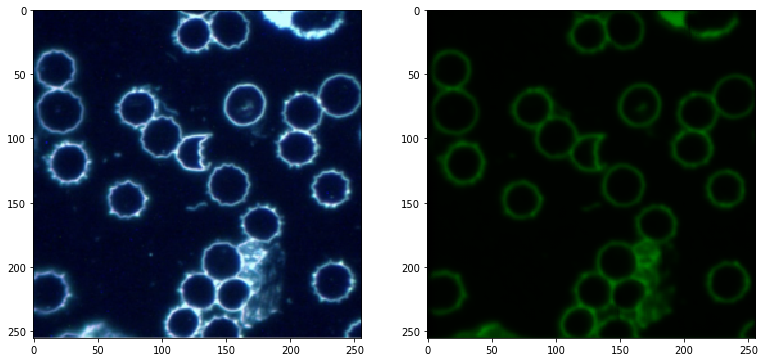

In [297]:
idx=0
fig = plt.figure(figsize=(20, 20))                
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X[idx,:,:,:])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(preds_train[idx,:,:,:])

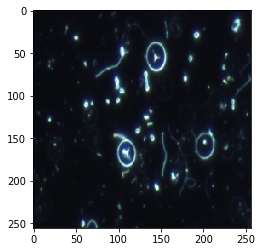

In [244]:
plt.imshow(X[301,:,:,:])